# Time Series Forecasting Guides

- https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
- https://skforecast.org/0.11.0/

# Imports

In [ ]:
!pip install xgboost mlflow skforecast lightgbm -q

In [ ]:
# !mlflow server --host 127.0.0.1 --port 8080

[2023-12-06 00:52:45 +0000] [47544] [INFO] Starting gunicorn 21.2.0
[2023-12-06 00:52:45 +0000] [47544] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2023-12-06 00:52:45 +0000] [47544] [ERROR] Retrying in 1 second.
[2023-12-06 00:52:46 +0000] [47544] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2023-12-06 00:52:46 +0000] [47544] [ERROR] Retrying in 1 second.
[2023-12-06 00:52:47 +0000] [47544] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2023-12-06 00:52:47 +0000] [47544] [ERROR] Retrying in 1 second.
[2023-12-06 00:52:48 +0000] [47544] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2023-12-06 00:52:48 +0000] [47544] [ERROR] Retrying in 1 second.
[2023-12-06 00:52:49 +0000] [47544] [ERROR] Connection in use: ('127.0.0.1', 8080)
[2023-12-06 00:52:49 +0000] [47544] [ERROR] Retrying in 1 second.
[2023-12-06 00:52:50 +0000] [47544] [ERROR] Can't connect to ('127.0.0.1', 8080)
Running the mlflow server failed. Please see the logs above for details.


In [ ]:
import  numpy as np
import  pandas as pd
import  matplotlib.pyplot as plt

from    datetime import datetime
import  copy
import  math
import  os
import  pickle
pd.set_option('display.max_columns', 200)

from    google.colab import drive
drive.mount('/content/gdrive')

PROJECT_PATH  = '/content/gdrive/MyDrive/OperAI/final-project'
VIZ_PATH      = os.path.join(PROJECT_PATH, 'viz')
DATA_PATH     = os.path.join(PROJECT_PATH, 'data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from    skforecast.ForecasterAutoreg import ForecasterAutoreg
from    sklearn.model_selection import train_test_split
from    sklearn.ensemble import RandomForestRegressor
from    sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from    sklearn.preprocessing import OneHotEncoder, StandardScaler

from    xgboost import XGBRegressor
from    lightgbm import LGBMRegressor
from    skforecast.ForecasterAutoreg import ForecasterAutoreg

from    tqdm.notebook import tqdm as blue_tqdm

# Data Import and Info

The model will be a national prediciton model, where each prediciton of daily deaths is based on individual models for each state. This will require aggregating the data at the state level. Over counties $j$ and states $i$ for age group $a$:

$$y^\text{national}_t = \sum_j \text{deaths}_{j,t}$$

$$\hat{y}^\text{national}_t = \sum_i f_{i}(X_{i,t})$$

where $f$ is a state-level model.

$X_{i,t}$ will comprise:

- Deaths
  - `deaths` (target)
  - `deaths` (lagged)
- Dose Administration Percentages
  - `dose_admin_pct_<Age group>`: Dose Administration Percentage (DAP)
  
  $$\text{doses administered}_{i,t,a} = \sum_{j \in i} \frac{\text{doses administered}_{j,a}}{\text{completeness}_{j,a}}$$

  $$\text{doses available}_{i,t,a} = \sum_{j \in i} \text{doses available}_{t,a} \times \text{population}_{j,t,a}$$

  $$\text{DAP}_{i,t,a} = \frac{\text{doses administered}_{i,t,a}}{\text{doses available}_{i,t,a}}$$



- Social Vulnerability Index (SVI) Population Exposure
  - `pop_in_<SVI category>`: Total number of people exposed to counties with given SVI index.
- Metro Area Population
  - `pop_in_<Metro category>`: Total number of people in metro versus non-metro areas.
- Time
  - `month`: categorical for seasonal trends
  - `dayofweek`: categorical for week data trends

In [ ]:
df = pd.read_pickle(os.path.join(DATA_PATH, 'df_state_timeseries_v2.pkl'))
df.sample(10)

,recip_state,date,phase_1_train,phase_1_test,phase_2_train,phase_2_test,month,dayofweek,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,cum_deaths,daily_deaths,cum_death_pct,daily_death_pct
23902,NY,2022-03-17,True,False,True,False,3,3,19453561.0,0.180525,0.186053,0.422521,0.210900,0.930143,0.069857,0.008733,0.007434,0.007579,0.008468,67336.0,28.0,0.003461,1.439325e-06
19406,GA,2021-12-21,True,False,True,False,12,1,10617423.0,0.131282,0.233374,0.337522,0.297823,0.830058,0.169942,0.005966,0.006485,0.005051,0.007517,29937.0,38.0,0.002820,3.579023e-06
2096,KS,2021-01-22,True,False,True,False,1,4,2913314.0,0.405590,0.156177,0.339111,0.099121,0.686964,0.313036,0.000000,0.000340,0.000376,0.000413,3616.0,22.0,0.001241,7.551538e-06
11065,SC,2021-07-13,True,False,True,False,7,1,5148714.0,0.000000,0.274363,0.465698,0.259939,0.855633,0.144367,0.000000,0.004922,0.005203,0.008081,9856.0,0.0,0.001914,0.000000e+00
4433,ID,2021-03-08,True,False,True,False,3,0,1787065.0,0.445062,0.190764,0.344173,0.020002,0.676260,0.323740,0.000000,0.000000,0.001791,0.004346,1890.0,11.0,0.001058,6.155344e-06
24010,PA,2022-03-19,True,False,True,False,3,5,12801989.0,0.281678,0.410672,0.183914,0.123736,0.886980,0.113020,0.007931,0.006671,0.006850,0.008702,44011.0,0.0,0.003438,0.000000e+00
32862,WV,2022-09-05,False,False,False,True,9,0,578759.0,0.335789,0.570802,0.093408,0.000000,0.309901,0.690099,0.004765,0.005156,0.005387,0.006518,1881.0,4.0,0.003250,6.911340e-06
21402,NH,2022-01-28,True,False,True,False,1,4,1359711.0,0.976787,0.000000,0.023213,0.000000,0.630595,0.369405,0.009135,0.006898,0.007068,0.009376,2181.0,11.0,0.001604,8.089954e-06
29156,OK,2022-06-26,False,True,True,False,6,6,578759.0,0.335789,0.570802,0.093408,0.000000,0.309901,0.690099,0.005840,0.005085,0.005317,0.007889,1829.0,5.0,0.003160,8.639175e-06
5834,GA,2021-04-04,True,False,True,False,4,6,10617423.0,0.131282,0.233374,0.337522,0.297823,0.830058,0.169942,0.000000,0.002245,0.002478,0.006174,18614.0,2.0,0.001753,1.883696e-07


In [ ]:
df.head()

,recip_state,date,phase_1_train,phase_1_test,phase_2_train,phase_2_test,month,dayofweek,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,cum_deaths,daily_deaths,cum_death_pct,daily_death_pct
0,AK,2020-12-13,True,False,True,False,12,6,722343.0,0.008043,0.831958,0.073799,0.0862,0.682731,0.317269,0.0,0.0,0.0,0.0,173.0,0.0,0.000239,0.000000
52,AK,2020-12-14,True,False,True,False,12,0,722343.0,0.008043,0.831958,0.073799,0.0862,0.682731,0.317269,0.0,0.0,0.0,0.0,173.0,0.0,0.000239,0.000000
104,AK,2020-12-15,True,False,True,False,12,1,722343.0,0.008043,0.831958,0.073799,0.0862,0.682731,0.317269,0.0,0.0,0.0,0.0,176.0,3.0,0.000244,0.000004
156,AK,2020-12-16,True,False,True,False,12,2,722343.0,0.008043,0.831958,0.073799,0.0862,0.682731,0.317269,0.0,0.0,0.0,0.0,178.0,2.0,0.000246,0.000003
208,AK,2020-12-17,True,False,True,False,12,3,722343.0,0.008043,0.831958,0.073799,0.0862,0.682731,0.317269,0.0,0.0,0.0,0.0,180.0,2.0,0.000249,0.000003


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34164 entries, 0 to 34163
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   recip_state             34164 non-null  object        
 1   date                    34164 non-null  datetime64[ns]
 2   phase_1_train           34164 non-null  bool          
 3   phase_1_test            34164 non-null  bool          
 4   phase_2_train           34164 non-null  bool          
 5   phase_2_test            34164 non-null  bool          
 6   month                   34164 non-null  category      
 7   dayofweek               34164 non-null  category      
 8   population              34164 non-null  float64       
 9   pct_pop_in_svi_ctgy_A   34164 non-null  float64       
 10  pct_pop_in_svi_ctgy_B   34164 non-null  float64       
 11  pct_pop_in_svi_ctgy_C   34164 non-null  float64       
 12  pct_pop_in_svi_ctgy_D   34164 non-null  float6

In [ ]:
STATES = list(df['recip_state'].unique())
print(STATES)
print(len(STATES))

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
52


# Preprocessing

## Convert Categorical to OneHot Vectors

# New Section

In [ ]:
X_vars_cat = [
    'month',
    'dayofweek',
]

In [ ]:
ohe = OneHotEncoder(sparse_output=False, drop='first').fit(df.loc[:, X_vars_cat])

ohe_df = pd.DataFrame(
    data = ohe.transform(df.loc[:, X_vars_cat]),
    columns = ohe.get_feature_names_out(),
    index = df.index
)

ohe_df.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df = pd.concat([df, ohe_df], axis=1)
df.columns

Index(['recip_state', 'date', 'phase_1_train', 'phase_1_test', 'phase_2_train',
       'phase_2_test', 'month', 'dayofweek', 'population',
       'pct_pop_in_svi_ctgy_A', 'pct_pop_in_svi_ctgy_B',
       'pct_pop_in_svi_ctgy_C', 'pct_pop_in_svi_ctgy_D', 'pct_pop_in_metro',
       'pct_pop_in_nonmetro', 'pct_doses_admin_5plus',
       'pct_doses_admin_12plus', 'pct_doses_admin_18plus',
       'pct_doses_admin_65plus', 'cum_deaths', 'daily_deaths', 'cum_death_pct',
       'daily_death_pct', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4',
       'dayofweek_5', 'dayofweek_6'],
      dtype='object')

## Segment into train and test

In [ ]:
id_vars = [
    'recip_state',
    'date',
]

X_vars_init = [
    'population',
    'pct_pop_in_svi_ctgy_A',
    'pct_pop_in_svi_ctgy_B',
    'pct_pop_in_svi_ctgy_C',
    'pct_pop_in_svi_ctgy_D',
    'pct_pop_in_metro',
    'pct_pop_in_nonmetro',
    'pct_doses_admin_5plus',
    'pct_doses_admin_12plus',
    'pct_doses_admin_18plus',
    'pct_doses_admin_65plus',
    'daily_death_pct',
]

X_vars_ohe = list(ohe.get_feature_names_out())

X_num = X_vars_init + X_vars_ohe

X_vars = id_vars + X_num

y_vars = [
    'recip_state',
    'date',
    'daily_deaths',
    # 'daily_death_pct'
]

In [ ]:
X_tr_phase1 = df.loc[df['phase_1_train'], X_vars]
X_te_phase1 = df.loc[df['phase_1_test'],  X_vars]
X_tr_phase2 = df.loc[df['phase_2_train'], X_vars]
X_te_phase2 = df.loc[df['phase_2_test'],  X_vars]

y_tr_phase1 = df.loc[df['phase_1_train'], y_vars]
y_te_phase1 = df.loc[df['phase_1_test'],  y_vars]
y_tr_phase2 = df.loc[df['phase_2_train'], y_vars]
y_te_phase2 = df.loc[df['phase_2_test'],  y_vars]


print('Shapes')
print('-'*60)
print(f'[Phase 1 Train]  x: {X_tr_phase1.shape}\t y: {y_tr_phase1.shape}')
print(f'[Phase 1 Test]   x: {X_te_phase1.shape}\t y: {y_te_phase1.shape}')
print(f'[Phase 2 Train]  x: {X_tr_phase2.shape}\t y: {y_tr_phase2.shape}')
print(f'[Phase 2 Test]   x: {X_te_phase2.shape}\t y: {y_te_phase2.shape}')
print('-'*60)

Shapes
------------------------------------------------------------
[Phase 1 Train]  x: (24648, 31)	 y: (24648, 3)
[Phase 1 Test]   x: (4732, 31)	 y: (4732, 3)
[Phase 2 Train]  x: (29380, 31)	 y: (29380, 3)
[Phase 2 Test]   x: (4784, 31)	 y: (4784, 3)
------------------------------------------------------------


In [ ]:
X_te_phase2['date'].min()

Timestamp('2022-07-01 00:00:00')

## Fit scaler on train and transform both train and test

In [ ]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit to train data
scaler1.fit(X_tr_phase1.loc[:, X_num])
scaler2.fit(X_tr_phase2.loc[:, X_num])

# Transform train and test data

## Phase 1---------------------------------------------------------

### X_tr_phase1
X_tr_phase1.loc[:, X_num] = pd.DataFrame(
    data = scaler1.transform(X_tr_phase1.loc[:, X_num]),
    columns = X_tr_phase1.loc[:, X_num].columns,
    index = X_tr_phase1.loc[:, X_num].index
)

### X_te_phase1
X_te_phase1.loc[:, X_num] = pd.DataFrame(
    data = scaler1.transform(X_te_phase1.loc[:, X_num]),
    columns = X_te_phase1.loc[:, X_num].columns,
    index = X_te_phase1.loc[:, X_num].index
)

## Phase 2---------------------------------------------------------
### X_tr_phase2
X_tr_phase2.loc[:, X_num] = pd.DataFrame(
    data = scaler1.transform(X_tr_phase2.loc[:, X_num]),
    columns = X_tr_phase2.loc[:, X_num].columns,
    index = X_tr_phase2.loc[:, X_num].index
)

### X_tr_phase1
X_te_phase2.loc[:, X_num] = pd.DataFrame(
    data = scaler1.transform(X_te_phase2.loc[:, X_num]),
    columns = X_te_phase2.loc[:, X_num].columns,
    index = X_te_phase2.loc[:, X_num].index
)

In [ ]:
X_te_phase2.head()

,recip_state,date,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,daily_death_pct,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
29380,AK,2022-07-01,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
29432,AK,2022-07-02,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
29484,AK,2022-07-03,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
29536,AK,2022-07-04,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
29588,AK,2022-07-05,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [ ]:
covid_datasets = (
    X_tr_phase1, y_tr_phase1,
    X_te_phase1, y_te_phase1,
    X_tr_phase2, y_tr_phase2,
    X_te_phase2, y_te_phase2
)

with open(os.path.join(DATA_PATH, 'covid_preprocessed_data_v3.pkl'), 'wb') as f:
    pickle.dump(covid_datasets, f)

# Models

In [ ]:
with open(os.path.join(DATA_PATH, 'covid_preprocessed_data_v3.pkl'), 'rb') as f:
    (X_tr_phase1, y_tr_phase1, X_te_phase1, y_te_phase1,
     X_tr_phase2, y_tr_phase2, X_te_phase2, y_te_phase2) = pickle.load(f)

print('Shapes')
print('-'*60)
print(f'[Phase 1 Train]  x: {X_tr_phase1.shape}\t y: {y_tr_phase1.shape}')
print(f'[Phase 1 Test]   x: {X_te_phase1.shape}\t y: {y_te_phase1.shape}')
print(f'[Phase 2 Train]  x: {X_tr_phase2.shape}\t y: {y_tr_phase2.shape}')
print(f'[Phase 2 Test]   x: {X_te_phase2.shape}\t y: {y_te_phase2.shape}')
print('-'*60)

X_te_phase2.head()

Shapes
------------------------------------------------------------
[Phase 1 Train]  x: (24648, 31)	 y: (24648, 3)
[Phase 1 Test]   x: (4732, 31)	 y: (4732, 3)
[Phase 2 Train]  x: (29380, 31)	 y: (29380, 3)
[Phase 2 Test]   x: (4784, 31)	 y: (4784, 3)
------------------------------------------------------------


,recip_state,date,population,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,daily_death_pct,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
29380,AK,2022-07-01,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
29432,AK,2022-07-02,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
29484,AK,2022-07-03,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
29536,AK,2022-07-04,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
29588,AK,2022-07-05,-0.803137,0.377298,1.230778,-0.890944,-0.992242,-2.590342,2.590342,1.340906,0.136414,0.192408,0.405424,0.374329,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,3.780254,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


## One Example State (LightGBM)

In [ ]:
X_AL = X_tr_phase1.loc[X_tr_phase1['recip_state'] == 'AL', :].set_index('date')
X_AL = X_AL.asfreq('D')
X_AL = X_AL.drop(columns=['recip_state', 'daily_death_pct'])
X_AL.head()

,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-13,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
2020-12-14,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-15,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-16,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,2.443479,-0.409253,-0.405733,-0.405733,-0.409253
2020-12-17,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,-0.545375,-1.706881,-1.826522,-2.094364,-0.366021,-0.387925,-0.259938,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,2.912044,-0.409253,-0.409253,2.443479,-0.405733,-0.405733,-0.409253


In [ ]:
X_AL_test = X_te_phase1.loc[X_te_phase1['recip_state'] == 'AL', :].set_index('date')
X_AL_test = X_AL_test.asfreq('D')
X_AL_test = X_AL_test.drop(columns=['recip_state', 'daily_death_pct'])
X_AL_test = X_AL_test.fillna(method='ffill')
X_AL_test.head()

,pct_pop_in_svi_ctgy_A,pct_pop_in_svi_ctgy_B,pct_pop_in_svi_ctgy_C,pct_pop_in_svi_ctgy_D,pct_pop_in_metro,pct_pop_in_nonmetro,pct_doses_admin_5plus,pct_doses_admin_12plus,pct_doses_admin_18plus,pct_doses_admin_65plus,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-01,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.391968,0.108507,0.156808,0.298248,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,2.464676,-0.405733,-0.409253
2022-04-02,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.392510,0.109238,0.157589,0.299379,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,2.464676,-0.409253
2022-04-03,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.392667,0.109433,0.157799,0.299631,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,2.443479
2022-04-04,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.393002,0.109885,0.158292,0.300329,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,-0.409253,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253
2022-04-05,-0.674412,-0.671086,0.70219,0.927563,-0.025184,0.025184,1.393512,0.110562,0.159021,0.301355,-0.366021,-0.387925,3.847077,-0.264532,-0.259938,-0.264532,-0.264532,-0.259938,-0.264532,-0.259938,-0.343401,2.443479,-0.409253,-0.409253,-0.405733,-0.405733,-0.409253


In [ ]:
y_AL = y_tr_phase1.loc[y_tr_phase1['recip_state'] == 'AL', :].set_index('date')
y_AL = y_AL.asfreq('D')
y_AL = y_AL.drop(columns='recip_state').squeeze()
y_AL.head()

date
2020-12-13    0.000000
2020-12-14    0.000000
2020-12-15    0.000004
2020-12-16    0.000015
2020-12-17    0.000011
Freq: D, Name: daily_death_pct, dtype: float64

In [ ]:
y_AL_test = y_te_phase1.loc[y_te_phase1['recip_state'] == 'AL', :].set_index('date')
y_AL_test = y_AL_test.asfreq('D')
y_AL_test = y_AL_test.fillna(method='ffill')
y_AL_test = y_AL_test.drop(columns='recip_state').squeeze()
y_AL_test.head()

date
2022-04-01    8.157963e-07
2022-04-02    3.875032e-06
2022-04-03    0.000000e+00
2022-04-04    4.282930e-06
2022-04-05    5.710574e-06
Freq: D, Name: daily_death_pct, dtype: float64

In [ ]:
lgbmr_forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123, n_jobs=3),
    lags = 21,
    differentiation = None
)

lgbmr_forecaster.fit(y=y_AL, exog=X_AL)
lgbmr_forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 42
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

ForecasterAutoreg 
Regressor: LGBMRegressor(n_jobs=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['pct_pop_in_svi_ctgy_A', 'pct_pop_in_svi_ctgy_B', 'pct_pop_in_svi_ctgy_C', 'pct_pop_in_svi_ctgy_D', 'pct_pop_in_metro', 'pct_pop_in_nonmetro', 'pct_doses_admin_5plus', 'pct_doses_admin_12plus', 'pct_doses_admin_18plus', 'pct_doses_admin_65plus', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'] 
Training range: [Timestamp('2020-12-13 00:00:00'), Timestamp('2022-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index freq

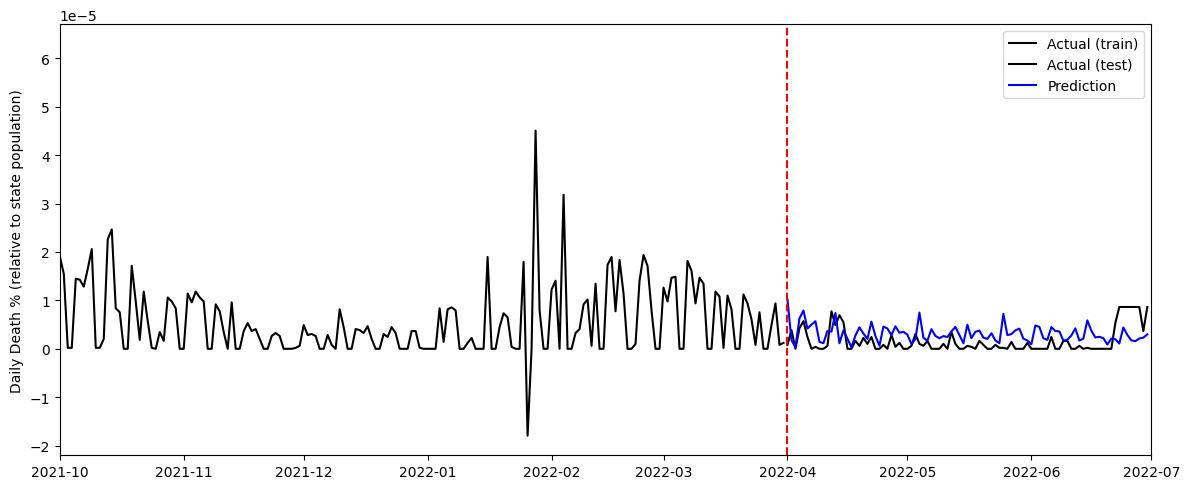

In [ ]:
y_pred = lgbmr_forecaster.predict(steps=len(X_AL_test), exog=X_AL_test)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_AL, color='black', label='Actual (train)')
ax.plot(y_AL_test, color='black', label='Actual (test)')
ax.plot(y_pred, color='blue', label='Prediction')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--')

ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 7, 1)))

ax.set_ylabel('Daily Death % (relative to state population)')

plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
lgbmr_forecaster.get_feature_importances()

,feature,importance
0,lag_1,97
1,lag_2,70
2,lag_3,109
3,lag_4,58
4,lag_5,72
5,lag_6,86
6,lag_7,110
7,lag_8,87
8,lag_9,77
9,lag_10,63


In [ ]:
rf_forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123, n_jobs=3),
    lags = 21,
    differentiation = None
)

rf_forecaster.fit(y=y_AL, exog=X_AL)
rf_forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_jobs=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Window size: 21 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['pct_pop_in_svi_ctgy_A', 'pct_pop_in_svi_ctgy_B', 'pct_pop_in_svi_ctgy_C', 'pct_pop_in_svi_ctgy_D', 'pct_pop_in_metro', 'pct_pop_in_nonmetro', 'pct_doses_admin_5plus', 'pct_doses_admin_12plus', 'pct_doses_admin_18plus', 'pct_doses_admin_65plus', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'] 
Training range: [Timestamp('2020-12-13 00:00:00'), Timestamp('2022-03-31 00:00:00')] 
Training index type: DatetimeIndex 
Training in

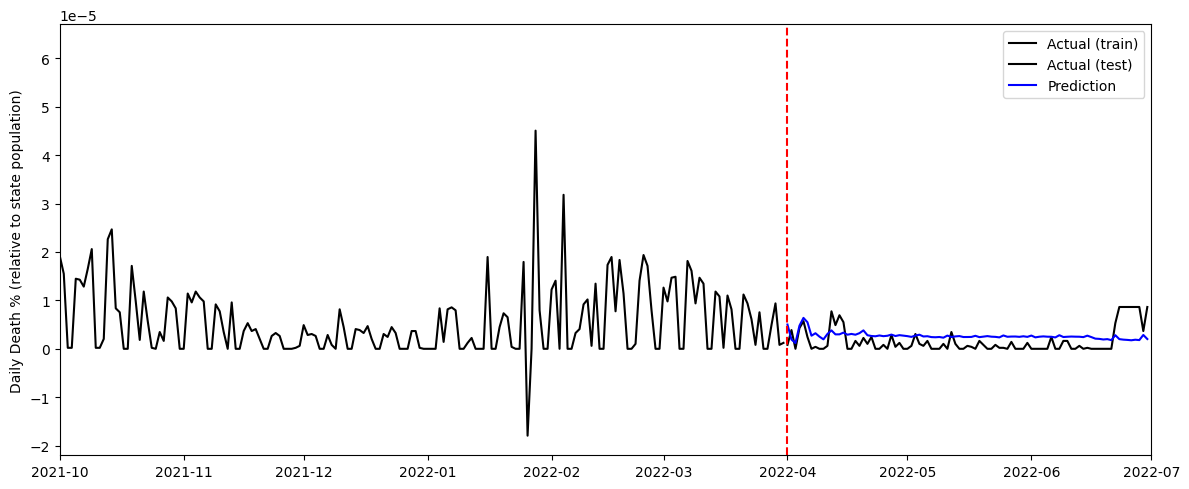

In [ ]:
y_pred = rf_forecaster.predict(steps=len(X_AL_test), exog=X_AL_test)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_AL, color='black', label='Actual (train)')
ax.plot(y_AL_test, color='black', label='Actual (test)')
ax.plot(y_pred, color='blue', label='Prediction')

ax.axvline(x=datetime(2022, 4, 1), color='red', linestyle='--')

ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 7, 1)))

ax.set_ylabel('Daily Death % (relative to state population)')

plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
rf_forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.089166
1,lag_2,0.045710
2,lag_3,0.032617
3,lag_4,0.023804
4,lag_5,0.016480
5,lag_6,0.109264
6,lag_7,0.250680
7,lag_8,0.024381
8,lag_9,0.027417
9,lag_10,0.007886


## Code for all states (LightGBM)

In [ ]:
def get_X_for_state(state_abbr, data=X_tr_phase1, use_death=False):

    out = data.loc[data['recip_state'] == state_abbr, :].set_index('date')
    out = out.asfreq('D')
    if use_death:
        drop_cols = ['recip_state']
    else:
        drop_cols = ['recip_state', 'daily_death_pct']
    out = out.drop(columns=drop_cols)

    return out

def get_y_for_state(state_abbr, data=y_tr_phase1):

    out = data.loc[data['recip_state'] == state_abbr, :].set_index('date')
    out = out.asfreq('D')
    out = out.drop(columns='recip_state').squeeze()

    return out

def get_data_for_state(state_abbr):

    X_tr_1 = get_X_for_state(state_abbr, data=X_tr_phase1, use_death=False)
    X_te_1 = get_X_for_state(state_abbr, data=X_te_phase1, use_death=False)
    y_tr_1 = get_y_for_state(state_abbr, data=y_tr_phase1)
    y_te_1 = get_y_for_state(state_abbr, data=y_te_phase1)

    X_tr_2 = get_X_for_state(state_abbr, data=X_tr_phase2, use_death=False)
    X_te_2 = get_X_for_state(state_abbr, data=X_te_phase2, use_death=False)
    y_tr_2 = get_y_for_state(state_abbr, data=y_tr_phase2)
    y_te_2 = get_y_for_state(state_abbr, data=y_te_phase2)

    X_te_concat = pd.concat([X_te_1, X_te_2], axis=0)
    y_te_concat = pd.concat([y_te_1, y_te_2], axis=0)
    y_full      = pd.concat([y_tr_2, y_te_2], axis=0)

    return (X_tr_1, X_te_1, y_tr_1, y_te_1,
            X_tr_2, X_te_2, y_tr_2, y_te_2,
            X_te_concat, y_te_concat, y_full)

def fit_forecaster(fcster, y, X):

    fcster.fit(y=y, exog=X)

    return fcster

def predict_and_plot(fcster_1,
                     fcster_2,
                     X_te_concat,
                     X_te_2,
                     y_full,
                     y_te_concat,
                     y_te_1,
                     state_abbr,
                     phase=1):

    y_pred_1 = fcster_1.predict(steps=len(X_te_concat), exog=X_te_concat)
    y_pred_2 = fcster_2.predict(steps=len(X_te_2), exog=X_te_2)

    fig, ax = plt.subplots(figsize=(9, 5))

    ax.plot(y_full, color='black', label='Actual')

    ax.plot(y_pred_1, color='blue', label='Prediction (Phase 1 Model)')
    ax.plot(y_pred_2, color='green', label='Prediction (Phase 2 Model)')

    vline_1 = datetime(2022, 4, 1)
    vline_2 = datetime(2022, 7, 1)
    ax.axvline(x=vline_1, color='red', linestyle='--')
    ax.axvline(x=vline_2, color='red', linestyle='--')

    ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 10, 1)))

    ax.set_ylabel('Daily Deaths')
    plt.title(state_abbr)
    plt.legend()
    plt.tight_layout()

    plt.show()

def forecast_state(state_abbr, fcster, phase):

    (X_tr_1, X_te_1, y_tr_1, y_te_1,
     X_tr_2, X_te_2, y_tr_2, y_te_2,
     X_te_concat, y_te_concat, y_full) = get_data_for_state(state_abbr)

    f1 = fcster
    f2 = copy.deepcopy(f1)

    fcster_1 = fit_forecaster(f1, y_tr_1, X_tr_1)
    fcster_2 = fit_forecaster(f2, y_tr_2, X_tr_2)

    predict_and_plot(fcster_1,
                     fcster_2,
                     X_te_concat,
                     X_te_2,
                     y_full,
                     y_te_concat,
                     y_te_1,
                     state_abbr,
                     phase=phase)


def forecast_national(fcster):

    phase_1_pred        = {}
    phase_1_feat_imp    = {}
    phase_1_mse         = {}
    phase_1_r2          = {}

    phase_2_pred        = {}
    phase_2_feat_imp    = {}
    phase_2_mse         = {}
    phase_2_r2          = {}

    concat_pred         = {}
    ground_truth        = {}

    for state_abbr in blue_tqdm(STATES):

        (X_tr_1, X_te_1, y_tr_1, y_te_1,
         X_tr_2, X_te_2, y_tr_2, y_te_2,
         X_te_concat, y_te_concat, y_full) = get_data_for_state(state_abbr)

        # Deep copies of forecasters to avoid state issues
        f1 = copy.deepcopy(fcster)
        f2 = copy.deepcopy(fcster)

        # Fit forecasters
        f1.fit(y=y_tr_1, exog=X_tr_1)
        f2.fit(y=y_tr_2, exog=X_tr_2)

        # Phase 1
        phase_1_pred[state_abbr]      = f1.predict(steps=len(X_te_1), exog=X_te_1)
        phase_1_feat_imp[state_abbr]  = f1.get_feature_importances()
        phase_1_mse[state_abbr]       = mean_squared_error(y_te_1, phase_1_pred[state_abbr])
        phase_1_r2[state_abbr]        = r2_score(y_te_1, phase_1_pred[state_abbr])

        # Phase 2
        phase_2_pred[state_abbr]      = f2.predict(steps=len(X_te_2), exog=X_te_2)
        phase_2_feat_imp[state_abbr]  = f2.get_feature_importances()
        phase_2_mse[state_abbr]       = mean_squared_error(y_te_2, phase_2_pred[state_abbr])
        phase_2_r2[state_abbr]        = r2_score(y_te_2, phase_2_pred[state_abbr])

        # Concatenated phases (for plotting)
        concat_pred[state_abbr]       = f1.predict(steps=len(X_te_concat), exog=X_te_concat)
        ground_truth[state_abbr]      = y_full


    pkg = (phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
           phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
           concat_pred, ground_truth)

    return pkg

def aggregate_national(fcster, pkg):

    (phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
     phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
     concat_pred, ground_truth) = pkg



def plot_national(pkg):
    (phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
     phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
     concat_pred, ground_truth) = pkg




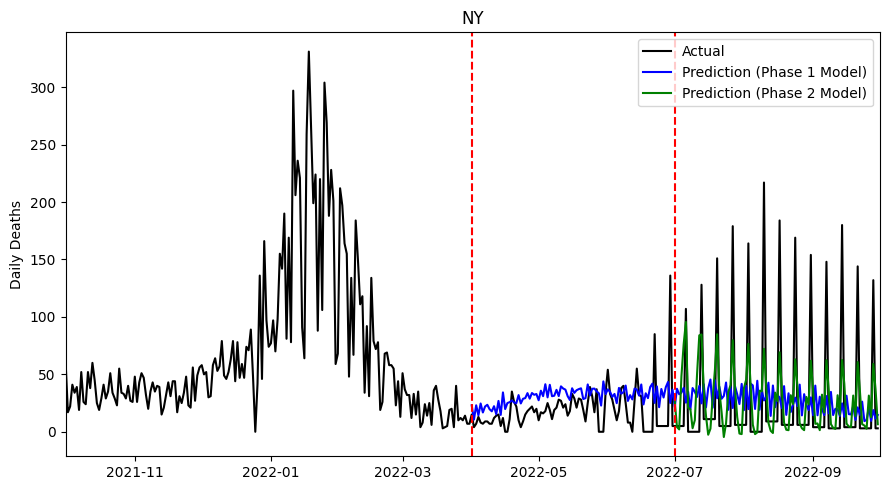

In [ ]:
my_forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123, n_jobs=3, verbose=-1),
    lags = 28,
    differentiation = None
)

forecast_state(state_abbr='NY', fcster=my_forecaster, phase=1)

In [ ]:
my_forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123, n_jobs=6, verbose=-1),
    lags = 21,
    differentiation = None
)

(phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
 phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
 concat_pred,  ground_truth) = forecast_national(my_forecaster)

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
phase_1_pred_natl = pd.DataFrame(phase_1_pred).sum(axis=1)
phase_2_pred_natl = pd.DataFrame(phase_2_pred).sum(axis=1)
concat_pred_natl  = pd.DataFrame(concat_pred).sum(axis=1)
ground_truth_natl = pd.DataFrame(ground_truth).sum(axis=1)

pred_natl = pd.DataFrame({
    'Phase 1 (ext)':  concat_pred_natl,
    'Phase 2':        phase_2_pred_natl,
    'Actual':         ground_truth_natl
    })

In [ ]:
# Phase 1
## Ground Truth
ph1_ground_truth_1m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 4, 1)) & (ground_truth_natl.index < datetime(2022, 5, 1))]
ph1_ground_truth_3m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 4, 1)) & (ground_truth_natl.index < datetime(2022, 7, 1))]

## Predictions
ph1_pred_1m = phase_1_pred_natl[(phase_1_pred_natl.index >= datetime(2022, 4, 1)) & (phase_1_pred_natl.index < datetime(2022, 5, 1))]
ph1_pred_3m = phase_1_pred_natl

# Phase 2
## Ground Truth
ph2_ground_truth_1m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 7, 1)) & (ground_truth_natl.index < datetime(2022, 8, 1))]
ph2_ground_truth_3m = ground_truth_natl[(ground_truth_natl.index >= datetime(2022, 7, 1)) & (ground_truth_natl.index < datetime(2022, 10, 1))]

## Predictions
ph2_pred_1m = phase_2_pred_natl[(phase_2_pred_natl.index >= datetime(2022, 7, 1)) & (phase_2_pred_natl.index < datetime(2022, 8, 1))]
ph2_pred_3m = phase_2_pred_natl


##################
#                #
#     METRICS    #
#                #
##################

ph1_r2_1m = r2_score(ph1_ground_truth_1m, ph1_pred_1m)
ph1_r2_3m = r2_score(ph1_ground_truth_3m, ph1_pred_3m)
ph2_r2_1m = r2_score(ph2_ground_truth_1m, ph2_pred_1m)
ph2_r2_3m = r2_score(ph2_ground_truth_3m, ph2_pred_3m)

ph1_mse_1m = math.sqrt(mean_squared_error(ph1_ground_truth_1m, ph1_pred_1m))
ph1_mse_3m = math.sqrt(mean_squared_error(ph1_ground_truth_3m, ph1_pred_3m))
ph2_mse_1m = math.sqrt(mean_squared_error(ph2_ground_truth_1m, ph2_pred_1m))
ph2_mse_3m = math.sqrt(mean_squared_error(ph2_ground_truth_3m, ph2_pred_3m))

ph1_mae_1m = mean_absolute_error(ph1_ground_truth_1m, ph1_pred_1m)
ph1_mae_3m = mean_absolute_error(ph1_ground_truth_3m, ph1_pred_3m)
ph2_mae_1m = mean_absolute_error(ph2_ground_truth_1m, ph2_pred_1m)
ph2_mae_3m = mean_absolute_error(ph2_ground_truth_3m, ph2_pred_3m)

r2s   = [ph1_r2_1m, ph1_r2_3m, ph2_r2_1m, ph2_r2_3m]
mses  = [ph1_mse_1m, ph1_mse_3m, ph2_mse_1m, ph2_mse_3m]
maes  = [ph1_mae_1m, ph1_mae_3m, ph2_mae_1m, ph2_mae_3m]
idx   = ['Phase 1, 1m' ,'Phase 1, 3m', 'Phase 2, 1m', 'Phase 2, 3m']

pd.DataFrame(
    {'r2': r2s, 'rmse': mses, 'mae': maes},
    index = idx
).style.format('{:,.2f}')

,r2,rmse,mae
"Phase 1, 1m",-1.06,729.17,586.91
"Phase 1, 3m",-2.63,916.18,810.09
"Phase 2, 1m",0.60,449.30,331.20
"Phase 2, 3m",0.49,703.34,559.26


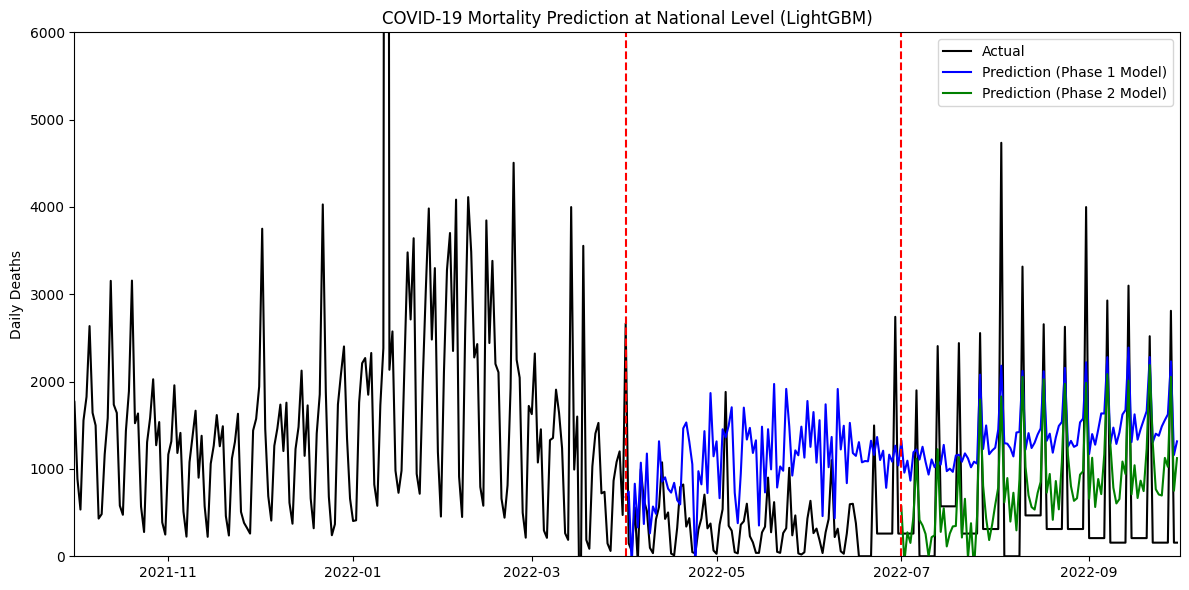

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(pred_natl['Actual'], color='black', label='Actual')

ax.plot(pred_natl['Phase 1 (ext)'], color='blue', label='Prediction (Phase 1 Model)')
ax.plot(pred_natl['Phase 2'], color='green', label='Prediction (Phase 2 Model)')

vline_1 = datetime(2022, 4, 1)
vline_2 = datetime(2022, 7, 1)
ax.axvline(x=vline_1, color='red', linestyle='--')
ax.axvline(x=vline_2, color='red', linestyle='--')

ax.set_xlim((datetime(2021, 10, 1), datetime(2022, 10, 1)))
ax.set_ylim((0, 6_000))

ax.set_ylabel('Daily Deaths')
plt.title('COVID-19 Mortality Prediction at National Level (LightGBM)')
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(VIZ_PATH, 'predictions', 'LightGBM-lag21.png'))

plt.show()

In [ ]:
my_forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123, n_jobs=6, verbose=-1),
    lags = 28,
    differentiation = None
)

(phase_1_pred, phase_1_feat_imp, phase_1_mse, phase_1_r2,
 phase_2_pred, phase_2_feat_imp, phase_2_mse, phase_2_r2,
 concat_pred,  ground_truth) = forecast_national(my_forecaster)